Output()

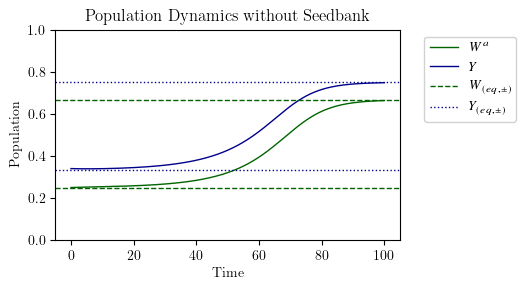

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import matplotlib as mpl
# LaTeX + fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['CMU Serif', 'Computer Modern Roman', 'DejaVu Serif', 'Times New Roman', 'Times']
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{newtxmath}'
mpl.rcParams['legend.framealpha'] = 0.9

width_pt = 390
inches_per_pt = 1.0/72.27
golden_ratio = (5**.5 - 1) / 2  # aesthetic figure height

fig_width = width_pt * inches_per_pt  # width in inches
fig_height = fig_width * golden_ratio # height in inches

def simulate_and_plot(W0, Y0, X0, W_birth, Y_birth, W_death, Y_death,
                       X_out, X_in,
                      Time, use_X, show_phase_only, Y_size=1, W_size=1):

    """
    Simulates population dynamics for species W, Y, and, optionally, interactions with X and Z.
    """

    X_scaler = X_out/X_in
    # Z disabled
    dt = 0.01
    t = np.arange(0, Time + dt, dt)
    W = np.zeros_like(t)
    Y = np.zeros_like(t)
    X = np.zeros_like(t)
    Z = np.zeros_like(t)
    W[0], Y[0], X[0], Z[0] = W0, Y0, X0/X_scaler, 0.0

    # Calculate equilibrium points
    Q1 = W_death / W_birth
    Q2 = Y_death / Y_birth

    disc_W = (1 - Q1 + Q2)**2 - 4 * Q2
    W_equil1 = W_equil2 = np.nan
    if disc_W >= 0:
        sqrt_disc_W = np.sqrt(disc_W)
        W_equil1 = 0.5 * ((1 - Q1 + Q2) + sqrt_disc_W)
        W_equil2 = 0.5 * ((1 - Q1 + Q2) - sqrt_disc_W)

    disc_Y = (1 - Q2 + Q1)**2 - 4 * Q1
    Y_equil1 = Y_equil2 = np.nan
    if disc_Y >= 0:
        sqrt_disc_Y = np.sqrt(disc_Y)
        Y_equil1 = 0.5 * ((1 - Q2 + Q1) + sqrt_disc_Y)
        Y_equil2 = 0.5 * ((1 - Q2 + Q1) - sqrt_disc_Y)



    for i in range(1, len(t)):
        # Base dynamics for W and Y
        dW = -W_birth * W[i - 1]**2 * Y[i - 1] + W_birth * W[i - 1] * Y[i - 1] - W_death * W[i - 1]
        dY = -Y_birth * Y[i - 1]**2 * W[i - 1] + Y_birth * W[i - 1] * Y[i - 1] - Y_death * Y[i - 1]
        
        # Modification by X and Z if enabled
        if use_X:
            dW += X_out * X[i - 1] - X_in * W[i - 1]
        # Z disabled
        
        # Dynamics for X and Z (feedback from W and Y)
        dX = -X_out * X[i - 1] + X_in * W[i - 1]
        # Z disabled

        # Update populations via Euler's method
        W[i] = W[i - 1] + dt * dW
        Y[i] = Y[i - 1] + dt * dY
        X[i] = X[i - 1] + dt * dX
        Z[i] = 0.0

        

    # Plotting
    
    X_plot = X * X_scaler
    # Z disabled
    if not show_phase_only:
        plt.figure(figsize=(12,5))
        # Plot X if enabled (rename to W^d)
        if use_X:
            plt.plot(t, X_plot, label=f'{X_scaler:.1f} ' + r'$W^d$', color='lightgreen')
        # Z disabled
        # Plot W^a and Y trajectories
        plt.plot(t, W, label=r'$W^a$', color='darkgreen')
        plt.plot(t, Y, label=r'$Y$', color='darkblue')
        # Equilibrium lines (if computed)
        if not np.isnan(W_equil1):
            plt.axhline(W_equil1, color='darkgreen', linestyle='--', label=r'$W_{(eq,\pm)}$')
        if not np.isnan(W_equil2):
            plt.axhline(W_equil2, color='darkgreen', linestyle='--')
        if not np.isnan(Y_equil1):
            plt.axhline(Y_equil1, color='darkblue', linestyle=':', label=r'$Y_{(eq,\pm)}$')
        if not np.isnan(Y_equil2):
            plt.axhline(Y_equil2, color='darkblue', linestyle=':')
        plt.xlabel('Time')
        plt.ylabel('Population')
        plt.title('Population Dynamics Over Time')
        plt.ylim(0, 1)
        plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
        # Update last_fig and optionally return for save
        plt.show()
    else:
        # Phase plot setup
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        axs[0].plot(W, Y, label='W vs Y', color='purple')
        # Z disabled
        axs[0].set_xlabel(r'$W^a$')
        axs[0].set_ylabel(r'$Y$')
        axs[0].set_title('Phase Plot: W vs Y')
        axs[0].set_xlim(0, 1)
        axs[0].set_ylim(0, 1)
        axs[0].grid(True)
        axs[0].legend(loc='upper left', bbox_to_anchor=(1.05, 1))
  

          # --- Constraint plot: sqrt(Q1) + sqrt(Q2) = 1 ---
        Q_vals = np.linspace(0, 1, 400)
        q1_grid, q2_grid = np.meshgrid(Q_vals, Q_vals)
        valid_region = (np.sqrt(q1_grid) + np.sqrt(q2_grid)) <= 1

        axs[1].contourf(Q_vals, Q_vals, valid_region, levels=[0.5, 1], colors=['#e0f7fa'], alpha=0.5)

        axs[1].plot(Q_vals, (1 - np.sqrt(Q_vals))**2, 'k--', label=r'$\sqrt{Q_1} + \sqrt{Q_2} = 1$')
        axs[1].scatter(Q1, Q2, color='red', label='Current (Q1, Q2)', zorder=5)

        # Annotate the sum
        qsum = np.sqrt(Q1) + np.sqrt(Q2)
        text = r"$\sqrt{Q_1} + \sqrt{Q_2} = $" + f"{qsum:.2f}"
        axs[1].text(Q1 + 0.02, Q2 + 0.02, text, fontsize=10, color='black')

        axs[1].set_xlabel('Q1 = W_death / W_birth')
        axs[1].set_ylabel('Q2 = Y_death / Y_birth')
        axs[1].set_title('Constraint Region')
        axs[1].set_xlim(0, 1)
        axs[1].set_ylim(0, 1)
        axs[1].legend(loc='upper left', bbox_to_anchor=(1.05, 1))

        plt.tight_layout()
        # Update last_fig and optionally return for save


# --- Slider Layout ---
slider_layout = widgets.Layout(width='250px')

# Column 1: Initial Values
W0_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=0.25, description="W₀",
                                style={'handle_color': 'darkgreen'}, layout=slider_layout)
X0_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=0.66, description="X₀",
                                style={'handle_color': 'lightgreen'}, layout=slider_layout)
Y0_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=0.34, description="Y₀",
                                style={'handle_color': 'darkblue'}, layout=slider_layout)
col1 = widgets.VBox([W0_slider, X0_slider, Y0_slider])

# Column 2: Birth and Death Parameters
W_birth_slider = widgets.FloatSlider(min=0.01, max=2.0, step=0.01, value=0.4, description="W⁺",
                                     style={'handle_color': 'darkgreen'}, layout=slider_layout)
W_death_slider = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.1, description="W⁻",
                                     style={'handle_color': 'darkgreen'}, layout=slider_layout)
Y_birth_slider = widgets.FloatSlider(min=0.01, max=2.0, step=0.01, value=0.9, description="Y⁺",
                                     style={'handle_color': 'darkblue'}, layout=slider_layout)
Y_death_slider = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.15, description="Y⁻",
                                     style={'handle_color': 'darkblue'}, layout=slider_layout)

col2 = widgets.VBox([W_birth_slider, W_death_slider, Y_birth_slider, Y_death_slider])

# Column 3: Parameters for X and Z
X_in_slider = widgets.FloatSlider(min=0.0, max=2.0, step=0.01, value=0.1, description="X⁺",
                                    style={'handle_color': 'lightgreen'}, layout=slider_layout)
X_out_slider = widgets.FloatSlider(min=0.0, max=2.0, step=0.01, value=0.1, description="X⁻",
                                    style={'handle_color': 'lightgreen'}, layout=slider_layout)

col3 = widgets.VBox([X_in_slider, X_out_slider])

# Column 4: Time, Toggles, and Additional Rates
Time_slider = widgets.IntSlider(min=10, max=1000, step=10, value=100, description="Time", layout=slider_layout)
phase_only_checkbox = widgets.Checkbox(value=False, description="Phase Plot Only", layout=slider_layout)
X_checkbox = widgets.Checkbox(value=True, description="Enable X", layout=slider_layout)
col4 = widgets.VBox([Time_slider, phase_only_checkbox, X_checkbox])

# Save PDF button and handler
save_button = widgets.Button(description='Save PDF')
def _on_save_clicked(b):
    import os, datetime
    # Build fresh figure from current slider values
    plt.close()
    mode = 'phase' if phase_only_checkbox.value else 'time'
    ts = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    base = f'BirthDeath_{mode}_{ts}'
    outdir = 'plots' if os.path.isdir('plots') else '.'
    pdf_path = os.path.join(outdir, base + '.pdf')
    # Grab current slider values
    W0 = W0_slider.value; Y0 = Y0_slider.value; X0 = X0_slider.value
    W_birth = W_birth_slider.value; Y_birth = Y_birth_slider.value
    W_death = W_death_slider.value; Y_death = Y_death_slider.value
    X_out = X_out_slider.value; X_in = X_in_slider.value
    Time = Time_slider.value; use_X = X_checkbox.value; show_phase_only = phase_only_checkbox.value

    # Recompute simulation locally (no reliance on interactive figure)
    import numpy as np
    X_scaler = X_out / X_in if X_in != 0 else 1.0
    dt = 0.01
    t = np.arange(0, Time + dt, dt)
    W = np.zeros_like(t); Y = np.zeros_like(t); X = np.zeros_like(t)
    W[0], Y[0], X[0] = W0, Y0, X0 / X_scaler

    # Equilibria for reference lines
    Q1 = W_death / W_birth if W_birth != 0 else np.inf
    Q2 = Y_death / Y_birth if Y_birth != 0 else np.inf
    disc_W = (1 - Q1 + Q2)**2 - 4 * Q2
    W_equil1 = W_equil2 = np.nan
    if disc_W >= 0:
        sqrt_disc_W = np.sqrt(disc_W)
        W_equil1 = 0.5 * ((1 - Q1 + Q2) + sqrt_disc_W)
        W_equil2 = 0.5 * ((1 - Q1 + Q2) - sqrt_disc_W)
    disc_Y = (1 - Q2 + Q1)**2 - 4 * Q1
    Y_equil1 = Y_equil2 = np.nan
    if disc_Y >= 0:
        sqrt_disc_Y = np.sqrt(disc_Y)
        Y_equil1 = 0.5 * ((1 - Q2 + Q1) + sqrt_disc_Y)
        Y_equil2 = 0.5 * ((1 - Q2 + Q1) - sqrt_disc_Y)

    for i in range(1, len(t)):
        dW = -W_birth * W[i - 1]**2 * Y[i - 1] + W_birth * W[i - 1] * Y[i - 1] - W_death * W[i - 1]
        dY = -Y_birth * Y[i - 1]**2 * W[i - 1] + Y_birth * W[i - 1] * Y[i - 1] - Y_death * Y[i - 1]
        if use_X:
            dW += X_out * X[i - 1] - X_in * W[i - 1]
        dX = -X_out * X[i - 1] + X_in * W[i - 1]
        W[i] = W[i - 1] + dt * dW
        Y[i] = Y[i - 1] + dt * dY
        X[i] = X[i - 1] + dt * dX

    # Build figure for save
    if not show_phase_only:
        fig = plt.figure(figsize=(fig_width, fig_height*9/10))
        if use_X:
            plt.plot(t, X * X_scaler, label=f'{X_scaler:.1f} ' + r'$W^d$', color='lightgreen', lw=1)
        plt.plot(t, W, label=r'$W^a$', color='darkgreen', lw=1)
        plt.plot(t, Y, label=r'$Y$', color='darkblue', lw=1)
        if not np.isnan(W_equil1):
            plt.axhline(W_equil1, color='darkgreen', linestyle='--', label=r'$W_{(eq,\pm)}$', lw=1)
        if not np.isnan(W_equil2):
            plt.axhline(W_equil2, color='darkgreen', linestyle='--', lw=1 )
        if not np.isnan(Y_equil1):
            plt.axhline(Y_equil1, color='darkblue', linestyle=':', label=r'$Y_{(eq,\pm)}$', lw=1)
        if not np.isnan(Y_equil2):
            plt.axhline(Y_equil2, color='darkblue', linestyle=':', lw=1 )
        plt.xlabel('Time'); plt.ylabel('Population'); plt.ylim(0, 1)
        plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
        plt.title(f'Population Dynamics'+ (' with Seedbank' if use_X else ' without Seedbank'))
        plt.tight_layout()
    else:
        fig, axs = plt.subplots(1, 2, figsize=(fig_width, fig_height))
        axs[0].plot(W, Y, label='W vs Y', color='purple')
        axs[0].set_xlabel(r'$W^a$'); axs[0].set_ylabel(r'$Y$'); axs[0].set_title('Phase Plot: W vs Y')
        axs[0].set_xlim(0, 1); axs[0].set_ylim(0, 1); axs[0].grid(True)
        axs[0].legend(loc='upper left', bbox_to_anchor=(1.05, 1))
        Q_vals = np.linspace(0, 1, 400); q1_grid, q2_grid = np.meshgrid(Q_vals, Q_vals)
        valid_region = (np.sqrt(q1_grid) + np.sqrt(q2_grid)) <= 1
        axs[1].contourf(Q_vals, Q_vals, valid_region, levels=[0.5, 1], colors=['#e0f7fa'], alpha=0.5)
        axs[1].plot(Q_vals, (1 - np.sqrt(Q_vals))**2, 'k--', label=r'$\sqrt{Q_1} + \sqrt{Q_2} = 1$')
        axs[1].scatter(Q1, Q2, color='red', label='Current (Q1, Q2)', zorder=5)
        qsum = np.sqrt(Q1) + np.sqrt(Q2)
        text = r'$\sqrt{Q_1} + \sqrt{Q_2} = $' + f'{qsum:.2f}'
        axs[1].text(Q1 + 0.02, Q2 + 0.02, text, fontsize=10, color='black')
        axs[1].set_xlabel('Q1 = W_death / W_birth'); axs[1].set_ylabel('Q2 = Y_death / Y_birth')
        axs[1].set_title('Constraint Region'); axs[1].set_xlim(0, 1); axs[1].set_ylim(0, 1)
        axs[1].legend(loc='upper left', bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
    preamble_orig = mpl.rcParams.get('text.latex.preamble', '')
    usetex_orig = mpl.rcParams.get('text.usetex', False)
    try:
        mpl.rcParams['text.latex.preamble'] = r'\usepackage{newtxmath}'
        mpl.rcParams['text.usetex'] = True
        fig.savefig(pdf_path, bbox_inches='tight')
    except Exception as e1:
        print('PDF save failed with newtxmath; trying mathptmx...', e1)
        try:
            mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
            mpl.rcParams['text.usetex'] = True
            fig.savefig(pdf_path, bbox_inches='tight')
        except Exception as e2:
            print('PDF save failed with LaTeX; falling back to non-TeX...', e2)
            mpl.rcParams['text.usetex'] = False
            fig.savefig(pdf_path, bbox_inches='tight')
    finally:
        mpl.rcParams['text.latex.preamble'] = preamble_orig
        mpl.rcParams['text.usetex'] = usetex_orig
    print(f'Saved {pdf_path}')
save_button.on_click(_on_save_clicked)

# Combine slider columns into a single control panel
col4 = widgets.VBox([Time_slider, phase_only_checkbox, X_checkbox, save_button])

controls = widgets.HBox([col1, col2, col3, col4])

# Bind the sliders to the simulation function using interactive_output
out = widgets.interactive_output(simulate_and_plot, {
    'W0': W0_slider, 'Y0': Y0_slider, 'X0': X0_slider,
    'W_birth': W_birth_slider, 'Y_birth': Y_birth_slider,
    'W_death': W_death_slider, 'Y_death': Y_death_slider,
    'W_birth': W_birth_slider, 'Y_birth': Y_birth_slider,
    'X_out': X_out_slider,
    'X_in': X_in_slider,
    'Time': Time_slider,
    'use_X': X_checkbox,
    'show_phase_only': phase_only_checkbox
})

# Display the interactive widgets and output
display(controls, out)